# 1. Exploring and ingesting satelligence data

Methodology based on following document: https://docs.google.com/document/d/1NHhOUOcJBOme_wv344cIMPIpdOX6_tBDCzIZeMY6h6I/edit



In [8]:
!pip install h3 --quiet
!pip install h3pandas h3ronpy mercantile --q

In [9]:
# from psycopg2.pool import ThreadedConnectionPool
import geopandas as gpd
import rasterio as rio
from h3ronpy import raster
from rasterstats import gen_point_query, zonal_stats

# import numpy as np

# import statistics

In [2]:
def convert_raster_h3(raster_path, vector_path, column="deforestat", resolution=6):
    with rio.open(raster_path) as src:
        gdf = raster.raster_to_geodataframe(
            src.read(1),
            src.transform,
            h3_resolution=resolution,
            nodata_value=src.profile["nodata"],
            compacted=False,
        )

        gdf.plot("value")
        gdf["h3index"] = gdf["h3index"].apply(hex)

    gdf_vector = gpd.read_file(vector_path)
    clean_gdf = gdf_vector[["gfw_fid", column, "geometry"]]

    _sum_calculated = []
    for i, row in clean_gdf.iterrows():
        filtered_gdf = clean_gdf[i : i + 1]
        # convert to h3
        h3_gdf = filtered_gdf.h3.polyfill_resample(resolution)
        # h3_gdf = h3_gdf.reset_index().rename(columns={'h3_polyfill':'h3index'})
        h3index_list = [f"0x{h3index}" for h3index in h3_gdf.index]
        # filter gdf by list and get value
        _sum = gdf[gdf["h3index"].isin(h3index_list)]["value"].sum()
        _sum_calculated.append(_sum)

    clean_gdf["estimate"] = _sum_calculated
    return clean_gdf


def buffer_stats(raster_path, vector_path, buffer=50000, stat_="sum"):
    """
    inputs:
    -------------
    raster_path: raster path for retriving the statisticts in EPSG:4326
    vector_path: path to point file in EPSG:4326
    buffer: distance in metres for coputing the buffer
    stats: stadistics to compute

    output
    -------
    array with statistics"""

    # open vector file
    gdf = gpd.read_file(vector_path)
    # check projection
    # if gdf.crs != True:
    #    print(gdf.crs)
    #    #project
    #    print('Dataset missing projection. Please assign one!')
    if gdf.crs and gdf.crs == "EPSG:4326":
        # reproject
        gdf_3857 = gdf.to_crs("EPSG:3857")
    ## TODO:add other validations

    # get buffer
    gdf_3857_buffer = gdf_3857.buffer(buffer)
    # reproject back to epsg4326
    gdf_4326_buffer = gdf_3857_buffer.to_crs("EPSG:4326")
    # get statistics
    vizz_stats = []
    for geom in gdf_4326_buffer:
        stats = zonal_stats(geom, raster_path, stats=stat_, all_touched=True)
        stat_sum = stats[0]["sum"]
        vizz_stats.append(stat_sum)
    # add stats in dataframe
    gdf["estimated"] = vizz_stats
    return gdf

## RASTER: Replicate satelligence analysis

Replicate satelligence analysis in raster format to double check outputs of calculations.

- Use case - Aceh, Sumatra, Indonesia.
- 3 indicators:
    - Deforestation
    - Carbon loss 
    - Biodiversity loss
    
### 1.  Deforestation:   
### 1.1 All deforestation in Aceh:

Procedure 

    1. Retrieve all deforestation pixels within a 50 km radius for all mills within the UML. 2. Calculate deforestation extent as sum of those pixels times the pixel’s area for each mill. 
    
    3. The indicator is then the total deforestation within the sourcing area of a mill 
    
    4. Commodity scenarios: analyze e.g. mean and percentage deforestation for given commodity as a whole (in country or world) compared to the same values for company X (i.e. for mills company X is sourcing from:
    
        a. Mean deforestation of all mills (all mills within a country, world) 
        b. % of deforestation within current supply chain (all mills of company X) compared to all deforestation within all mills 

#### Generate tiles for area of interest:

We perform the calculation in bunches in order to be more efficient. To do this, we generate tiles in zoom level 12 that will be used to clip the geometry and calculate the deforestation in ecah part.

### 1.2 Deforestation in mill locations:

In [81]:
!gdal_calc.py --calc "A*6.69019042035408517*6.69019042035408517* 0.0001" --format GTiff --type Float32 --NoDataValue 0.0 -A "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01 (1).tif" --A_band 1 --outfile "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_area_ha.tif"


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 

48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 

71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 

94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 96.. 96.. 96.. 96.. 

In [56]:
gdf = buffer_stats(
    "../../datasets/processed/Satelligence_data/test_rasters_2/Deforestation_2021_2022_area_ha.tif",
    "../../datasets/processed/palm_oil_mills/satelligence_mills_4326_point.shp",
    buffer=50000,
    stat_="sum",
)
gdf.head()

,fid,gfw_fid,uml_id,group_name,parent_com,mill_name,rspo_statu,rspo_type,date,latitude,...,district,confidence,alternativ,gfw_area__,gfw_geosto,deforestat,biodiversi,carbon,geometry,estimated
0,1.0,706,PO1000004155,IBRIS PALM,DELIMA MAKMUR,DELIMA MAKMUR,Not RSPO Certified,None,2021-07-14,2.24508,...,Aceh Singkil,1-Fully Verified,LAE TANGGA,0,256170af-2d4f-4a5b-a417-b981205849be,349.5068535490499,200.138293908663,57812.37323319753,POINT (98.02851 2.24508),349.507996
1,2.0,717,PO1000004167,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 1,Not RSPO Certified,None,2021-07-14,2.314164,...,Aceh Singkil,1-Fully Verified,None,0,b2d76be0-1ace-7a54-8e5e-74bb01111787,444.9278149230584,295.5592552826714,74432.2796810086,POINT (97.99572 2.31416),444.931091
2,3.0,264,PO1000001775,SOCFIN,SOCFIN INDONESIA,LAE BUTAR,RSPO Certified,"RSPO Certified, IP",2021-07-14,2.391111,...,Aceh Singkil,1-Fully Verified,None,0,aff58ced-c18c-a5d8-d084-eb5a6a74416b,552.3038111406324,400.8360709155834,95543.40760696075,POINT (97.95667 2.39111),552.307617
3,4.0,738,PO1000004197,UNKNOWN,NAFASINDO,NAFASINDO,Not RSPO Certified,None,2021-07-14,2.43594,...,Aceh Singkil,1-Fully Verified,None,0,3cee289b-cdd6-a33d-e0f6-15ea8e7423fa,621.1470874150178,469.4242228971635,109557.3760590317,POINT (97.91529 2.43594),621.152405
4,5.0,1516,PO1000008193,TENERA LESTARI,ENSEM LESTARI,ENSEM LESTARI,Not RSPO Certified,None,2021-07-14,2.456777,...,Aceh Singkil,1-Fully Verified,None,0,128b643f-9046-0f4e-c71e-59ca37fb221f,600.0120538952435,448.9605690952982,104970.0756673934,POINT (98.06502 2.45678),600.016846


## H3: Replicate pipe for ingesting satelligence data into the ddbb

### 1- Ingest summing the pixels with deforestation in the resampling - AREA

 Ingest by summing the pixel values * area (masked values) in the resampling.


In [82]:
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 0.0833333333333286 0.0833333333333286 -r sum  -multi -of GTiff "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_area_ha.tif" "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_areaSum_ha.tif"

Creating output file that is 40P x 48L.
Processing ../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_area_ha.tif [1/1] : 0Using internal nodata values (e.g. 0) for image ../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_area_ha.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [4]:
gdf_sat = gpd.read_file(
    "../../datasets/processed/Satelligence_data/test_rasters_2/satelligence_mills_4326_50kmbuffer.shp"
)

clean_sat_mills = gdf_sat[["gfw_fid", "deforestat", "biodiversi", "carbon", "geometry"]]
clean_sat_mills.head()

,gfw_fid,deforestat,biodiversi,carbon,geometry
0,706,349.5068535490499,200.138293908663,57812.37323319753,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ..."
1,717,444.9278149230584,295.5592552826714,74432.2796810086,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ..."
2,264,552.3038111406324,400.8360709155834,95543.40760696075,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ..."
3,738,621.1470874150178,469.4242228971635,109557.3760590317,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ..."
4,1516,600.0120538952435,448.9605690952982,104970.0756673934,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ..."


### Calculate deforestation with res6:

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,gfw_fid,deforestat,geometry,estimate
0,706,349.5068535490499,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ...",669.573975
1,717,444.9278149230584,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ...",860.595398
2,264,552.3038111406324,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ...",1122.990967
3,738,621.1470874150178,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ...",1416.131714
4,1516,600.0120538952435,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ...",1104.849243


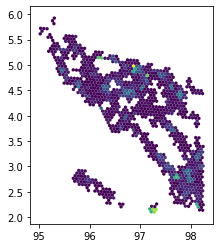

In [18]:
gdf = convert_raster_h3(
    "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_areaSum_ha.tif",
    "../../datasets/processed/Satelligence_data/test_rasters_2/satelligence_mills_4326_50kmbuffer.shp",
    column="deforestat",
    resolution=6,
)
gdf.head()

In [19]:
gdf.to_csv("../../datasets/processed/Satelligence_data/Deforestation_area_res6_h3_stats.csv")

### Calculate deforestation with res5:

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,gfw_fid,deforestat,geometry,estimate
0,706,349.5068535490499,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ...",69.865265
1,717,444.9278149230584,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ...",122.547684
2,264,552.3038111406324,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ...",140.941498
3,738,621.1470874150178,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ...",237.884247
4,1516,600.0120538952435,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ...",147.027191


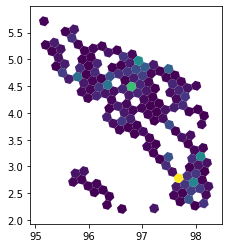

In [20]:
gdf = convert_raster_h3(
    "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_areaSum_ha.tif",
    "../../datasets/processed/Satelligence_data/test_rasters_2/satelligence_mills_4326_50kmbuffer.shp",
    column="deforestat",
    resolution=5,
)
gdf.head()

In [21]:
gdf.to_csv("../../datasets/processed/Satelligence_data/Deforestation_area_res5_h3_stats.csv")

### 2- Ingest summing the pixels with deforestation in the resampling - COUNT

In [188]:
!gdal_calc.py --calc "A*1" --format GTiff --type Float32 --NoDataValue 0.0 -A "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01 (1).tif" --A_band 1 --outfile "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_mask.tif"


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 

48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 

71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 

94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 96.. 96.. 96.. 96.. 

In [189]:
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 0.0833333333333286 0.0833333333333286 -r sum  -multi -of GTiff "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_mask.tif" "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_Sum_count.tif"

Creating output file that is 40P x 48L.
Processing ../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_mask.tif [1/1] : 0Using internal nodata values (e.g. 0) for image ../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_mask.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


### Calculate deforestation with res6:

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,gfw_fid,deforestat,geometry,estimate
0,706,349.5068535490499,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ...",669.573916
1,717,444.9278149230584,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ...",860.595433
2,264,552.3038111406324,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ...",1122.990978
3,738,621.1470874150178,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ...",1416.131728
4,1516,600.0120538952435,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ...",1104.849319


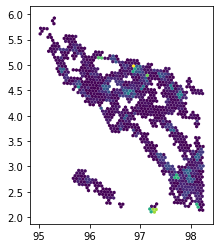

In [96]:
gdf = convert_raster_h3(
    "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_Sum_count.tif",
    "../../datasets/processed/Satelligence_data/test_rasters_2/satelligence_mills_4326_50kmbuffer.shp",
    column="deforestat",
    resolution=6,
)
_estimated = [el * 6.69019042035408517 * 6.69019042035408517 * 0.0001 for el in gdf["estimate"]]
gdf["estimate"] = _estimated
gdf.head()

### 3- Ingest summing the pixels with deforestation in the resampling - DENSITY

In [202]:
!gdal_calc.py --calc "A/1929012.345678793" --format GTiff --type Float32 --NoDataValue 0.0 -A "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_Sum_count.tif" --A_band 1 --outfile "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_Density.tif"


0.. 100 - Done


### Calculate deforestation with res6:

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,gfw_fid,deforestat,geometry,estimate
0,706,349.5068535490499,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ...",280.183496
1,717,444.9278149230584,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ...",360.116453
2,264,552.3038111406324,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ...",469.915963
3,738,621.1470874150178,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ...",592.580812
4,1516,600.0120538952435,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ...",462.324545


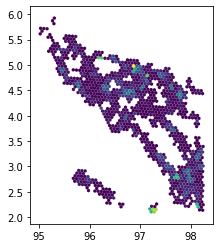

In [22]:
gdf = convert_raster_h3(
    "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_Density.tif",
    "../../datasets/processed/Satelligence_data/test_rasters_2/satelligence_mills_4326_50kmbuffer.shp",
    column="deforestat",
    resolution=6,
)
_estimated = [el * 3612.9 for el in gdf["estimate"]]
gdf["estimate"] = _estimated
gdf.head()

In [23]:
gdf.to_csv("../../datasets/processed/Satelligence_data/Deforestation_density_res6_h3_stats.csv")

### Calculate deforestation with res5:

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,gfw_fid,deforestat,geometry,estimate
0,706,349.5068535490499,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ...",204.646269
1,717,444.9278149230584,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ...",358.961277
2,264,552.3038111406324,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ...",412.839641
3,738,621.1470874150178,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ...",696.800144
4,1516,600.0120538952435,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ...",430.665555


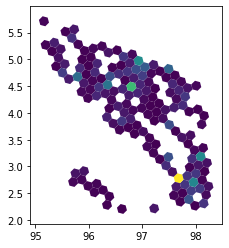

In [100]:
gdf = convert_raster_h3(
    "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_Density.tif",
    "../../datasets/processed/Satelligence_data/test_rasters_2/satelligence_mills_4326_50kmbuffer.shp",
    column="deforestat",
    resolution=5,
)
_estimated = [el * 25290.33 for el in gdf["estimate"]]
gdf["estimate"] = _estimated
gdf.head()

### 4- Ingest summing the pixels with deforestation in the resampling - centroid

In [269]:
centroids_gdf = gpd.read_file(
    "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_Sum_count_h3/centroids.shp"
)
centroids_gdf.head()

,h3index,value,geometry
0,0x866552937ffffff,6390.222168,POINT (96.43162 5.12213)
1,0x86655664fffffff,6390.222168,POINT (96.46763 5.17446)
2,0x86655666fffffff,6390.222168,POINT (96.49527 5.11735)
3,0x86657269fffffff,44.000000,POINT (97.22921 3.47041)
4,0x866509497ffffff,155.000000,POINT (98.04976 4.55916)


In [270]:
src_raster = (
    "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_Density.tif"
)

In [271]:
gpq_stats_h3_centroid = gen_point_query(
    centroids_gdf,
    src_raster,
    interpolate="bilinear",
    property_name="bilinear_stat",
    geojson_out=True,
)

In [274]:
h3_point_stats = []
for gen in gpq_stats_h3_centroid:
    h3index = gen["properties"]["h3index"]
    value = gen["properties"]["bilinear_stat"]
    h3_point_stats.append({"h3index": h3index, "value": value})

In [275]:
gdf_pointStats = gpd.GeoDataFrame(h3_point_stats)
gdf_pointStats.head()

,h3index,value
0,0x86655666fffffff,0.002016
1,0x86657269fffffff,0.000023
2,0x866509497ffffff,0.000080
3,0x866556c47ffffff,0.002455
4,0x866556c77ffffff,0.000183


In [276]:
# get values for each mill
def_sum_calculated = []
for i, row in clean_sat_mills.iterrows():
    filtered_gdf = clean_sat_mills[i : i + 1]
    # convert to h3
    h3_gdf = filtered_gdf.h3.polyfill_resample(6)
    h3index_list = [f"0x{h3index}" for h3index in h3_gdf.index]
    # filter gdf by list and get value
    # 3617 is the area of the hexagon for res6 in
    def_sum = gdf_pointStats[gdf_pointStats["h3index"].isin(h3index_list)]["value"].sum() * 3612.9
    def_sum_calculated.append(def_sum)

In [277]:
clean_sat_mills["vizz_pointStat_bilinear_res6"] = def_sum_calculated
clean_sat_mills.head()

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,gfw_fid,deforestat,geometry,vizz_h3_def,vizz_h3_def_res5,vizz_h3_def_sum_res6,vizz_h3_def_density_res6,vizz_h3_def_density_res5,vizz_h3_def_density_res7,vizz_pointStat_res6,vizz_pointStat_res5,vizz_pointStat_res7,vizz_pointStat_bilinear_res6
0,706,349.5068535490499,"MULTIPOLYGON (((98.14902 2.13469, 98.14809 2.1...",560.544861,63.809914,560.544857,234.560211,186.909221,231.401121,199.776774,236.914138,227.961338,233.588704
1,717,444.9278149230584,"MULTIPOLYGON (((98.14902 2.13469, 98.14809 2.1...",745.314514,115.216705,745.314570,311.877149,337.487756,304.880902,274.914993,305.928887,301.532865,309.002917
2,264,552.3038111406324,"MULTIPOLYGON (((98.14902 2.13469, 98.14809 2.1...",978.444763,115.216705,978.444883,409.430680,337.487756,389.348195,347.807809,305.928887,379.853230,391.183398
3,738,621.1470874150178,"MULTIPOLYGON (((98.14902 2.13469, 98.14809 2.1...",1270.436890,223.985703,1270.436874,531.614798,656.089080,474.391836,440.995694,462.876846,475.096984,492.348037
4,1516,600.0120538952435,"MULTIPOLYGON (((98.14902 2.13469, 98.14809 2.1...",963.031921,140.251221,963.031963,402.981160,410.817765,404.388462,365.531112,431.031216,403.059286,408.697513


In [278]:
clean_sat_mills.to_csv(
    "../../datasets/processed/Satelligence_data/Deforestation_comparative_sat_vizz_centroid.csv"
)

## Carbon indicator: 

Procedure:

    1. Multiply carbon stock to Indicator 1 for aboveground biomass loss. 
    2. Use the same methodology as in indicator 1 to determine per mill carbon loss and compare with other mills inside/outside supply chain of company X. 


### RASTER: Replicate satelligence analysis

In [52]:
# download carbon layer to same resolution as deforestation area file
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 6e-05 6e-05 -r near -te 94.99998 2.1 98.29998 6.10002 -te_srs EPSG:4326 -multi -of GTiff '../../datasets/processed/Satelligence_data/carbon_analysis/AboveGroundBiomass_GLO_2001-01-01-2002-01-01.tif' '../../datasets/processed/Satelligence_data/carbon_analysis/AboveGroundBiomass_GLO_2001-01-01-2002-01-01_downsample.tif'

Creating output file that is 55000P x 66667L.
Processing ../../datasets/processed/Satelligence_data/carbon_analysis/AboveGroundBiomass_GLO_2001-01-01-2002-01-01.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [53]:
# multiply the two rasters using gdal calc
!gdal_calc.py --calc "A*B" --format GTiff --type Float32 -A '../../datasets/processed/Satelligence_data/carbon_analysis/AboveGroundBiomass_GLO_2001-01-01-2002-01-01_downsample.tif' --A_band 1 -B '../../datasets/processed/Satelligence_data/test_rasters_2/Deforestation_2021_2022_area_ha.tif' --outfile '../../datasets/processed/Satelligence_data/carbon_analysis/carbon_loss_T_downsample.tif'

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 

6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 

11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 

16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 

21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 

26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 

31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 

35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 36.. 

38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 

43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 

48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 

53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 53.. 

58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 58.. 

63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 

68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 

73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 73.. 

78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 

83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 

87.. 87.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 88.. 

92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 

97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 98.. 

In [54]:
gdf = buffer_stats(
    "../../datasets/processed/Satelligence_data/carbon_analysis/carbon_loss_T_downsample.tif",
    "../../datasets/processed/palm_oil_mills/satelligence_mills_4326_point.shp",
    buffer=50000,
    stat_="sum",
)
gdf.head()

,fid,gfw_fid,uml_id,group_name,parent_com,mill_name,rspo_statu,rspo_type,date,latitude,...,district,confidence,alternativ,gfw_area__,gfw_geosto,deforestat,biodiversi,carbon,geometry,estimated
0,1.0,706,PO1000004155,IBRIS PALM,DELIMA MAKMUR,DELIMA MAKMUR,Not RSPO Certified,None,2021-07-14,2.24508,...,Aceh Singkil,1-Fully Verified,LAE TANGGA,0,256170af-2d4f-4a5b-a417-b981205849be,349.5068535490499,200.138293908663,57812.37323319753,POINT (98.02851 2.24508),57812.324219
1,2.0,717,PO1000004167,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 1,Not RSPO Certified,None,2021-07-14,2.314164,...,Aceh Singkil,1-Fully Verified,None,0,b2d76be0-1ace-7a54-8e5e-74bb01111787,444.9278149230584,295.5592552826714,74432.2796810086,POINT (97.99572 2.31416),74432.179688
2,3.0,264,PO1000001775,SOCFIN,SOCFIN INDONESIA,LAE BUTAR,RSPO Certified,"RSPO Certified, IP",2021-07-14,2.391111,...,Aceh Singkil,1-Fully Verified,None,0,aff58ced-c18c-a5d8-d084-eb5a6a74416b,552.3038111406324,400.8360709155834,95543.40760696075,POINT (97.95667 2.39111),95543.171875
3,4.0,738,PO1000004197,UNKNOWN,NAFASINDO,NAFASINDO,Not RSPO Certified,None,2021-07-14,2.43594,...,Aceh Singkil,1-Fully Verified,None,0,3cee289b-cdd6-a33d-e0f6-15ea8e7423fa,621.1470874150178,469.4242228971635,109557.3760590317,POINT (97.91529 2.43594),109557.250000
4,5.0,1516,PO1000008193,TENERA LESTARI,ENSEM LESTARI,ENSEM LESTARI,Not RSPO Certified,None,2021-07-14,2.456777,...,Aceh Singkil,1-Fully Verified,None,0,128b643f-9046-0f4e-c71e-59ca37fb221f,600.0120538952435,448.9605690952982,104970.0756673934,POINT (98.06502 2.45678),104969.828125


In [55]:
# export to csv
gdf.to_csv("../../datasets/processed/Satelligence_data/carbon_analysis/carbon_loss_T_stats_v2.csv")

In [4]:
## upsample the carbon_loss_T for ingesting
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 0.0833333333333286 0.0833333333333286 -r sum  -multi -of GTiff '../../datasets/processed/Satelligence_data/carbon_analysis/carbon_loss_T_downsample.tif' '../../datasets/processed/Satelligence_data/carbon_analysis/carbon_loss_T_sum_upsample.tif'

Creating output file that is 40P x 48L.
Processing ../../datasets/processed/Satelligence_data/carbon_analysis/carbon_loss_T_downsample.tif [1/1] : 0Using internal nodata values (e.g. 3.40282e+38) for image ../../datasets/processed/Satelligence_data/carbon_analysis/carbon_loss_T_downsample.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


### Ingesting the data precalculated:

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,gfw_fid,carbon,geometry,estimate
0,706,57812.37323319753,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ...",111082.382812
1,717,74432.2796810086,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ...",146149.562500
2,264,95543.40760696075,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ...",197099.781250
3,738,109557.3760590317,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ...",253342.375000
4,1516,104970.0756673934,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ...",193674.187500


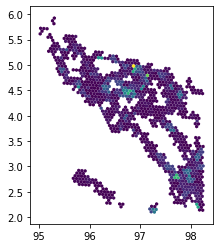

In [31]:
gdf_res6 = convert_raster_h3(
    "../../datasets/processed/Satelligence_data/carbon_analysis/carbon_loss_T_sum_upsample.tif",
    "../../datasets/processed/Satelligence_data/test_rasters_2/satelligence_mills_4326_50kmbuffer.shp",
    column="carbon",
    resolution=6,
)
gdf_res6.head()

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,gfw_fid,carbon,geometry,estimate
0,706,57812.37323319753,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ...",10773.863281
1,717,74432.2796810086,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ...",20534.408203
2,264,95543.40760696075,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ...",23541.343750
3,738,109557.3760590317,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ...",41870.093750
4,1516,104970.0756673934,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ...",24832.167969


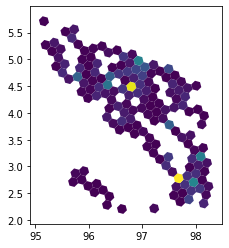

In [32]:
gdf_res5 = convert_raster_h3(
    "../../datasets/processed/Satelligence_data/carbon_analysis/carbon_loss_T_sum_upsample.tif",
    "../../datasets/processed/Satelligence_data/test_rasters_2/satelligence_mills_4326_50kmbuffer.shp",
    column="carbon",
    resolution=5,
)

gdf_res5.head()

### Ingesting raw data and calculate it on ddbb:



In [12]:
## upsample the carbon_loss_T for ingesting
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 0.0833333333333286 0.0833333333333286 -r sum  -multi -of GTiff '../../datasets/processed/Satelligence_data/carbon_analysis/AboveGroundBiomass_GLO_2001-01-01-2002-01-01.tif' '../../datasets/processed/Satelligence_data/carbon_analysis/AboveGroundBiomass_GLO_2001-01-01-2002-01-01_upsample.tif'

Creating output file that is 120P x 120L.
Processing ../../datasets/processed/Satelligence_data/carbon_analysis/AboveGroundBiomass_GLO_2001-01-01-2002-01-01.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


,h3index,value,geometry
0,0x86655475fffffff,0.000236,"POLYGON ((96.34271 3.95695, 96.34547 3.99329, ..."
1,0x8665506e7ffffff,0.000112,"POLYGON ((95.49100 4.95352, 95.49369 4.98998, ..."
2,0x8665540c7ffffff,0.000358,"POLYGON ((96.48875 3.78162, 96.49153 3.81794, ..."
3,0x866556a47ffffff,0.000346,"POLYGON ((96.50300 4.38386, 96.50579 4.42026, ..."
4,0x866556a6fffffff,0.000346,"POLYGON ((96.46707 4.33165, 96.46985 4.36804, ..."


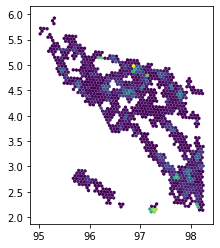

In [11]:
raster_path = (
    "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_Density.tif"
)
with rio.open(raster_path) as src:
    gdf_densres6 = raster.raster_to_geodataframe(
        src.read(1),
        src.transform,
        h3_resolution=6,
        nodata_value=src.profile["nodata"],
        compacted=False,
    )
    gdf_densres6.plot("value")
    gdf_densres6["h3index"] = gdf_densres6["h3index"].apply(hex)
gdf_densres6.head()

,h3index,value,geometry
0,0x86652b68fffffff,289,"POLYGON ((99.18197 2.86583, 99.18503 2.90196, ..."
1,0x86652b6d7ffffff,289,"POLYGON ((99.11896 2.87070, 99.12201 2.90683, ..."
2,0x86652b6f7ffffff,289,"POLYGON ((99.14588 2.81408, 99.14893 2.85020, ..."
3,0x866553d87ffffff,289,"POLYGON ((95.55106 5.33424, 95.55375 5.37075, ..."
4,0x866553d97ffffff,289,"POLYGON ((95.58695 5.38666, 95.58965 5.42317, ..."


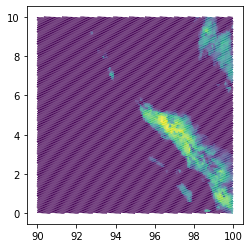

In [14]:
raster_path = "../../datasets/processed/Satelligence_data/carbon_analysis/AboveGroundBiomass_GLO_2001-01-01-2002-01-01_upsample.tif"
with rio.open(raster_path) as src:
    gdf_carbres6 = raster.raster_to_geodataframe(
        src.read(1), src.transform, h3_resolution=6, compacted=False
    )
    gdf_carbres6.plot("value")
    gdf_carbres6["h3index"] = gdf_carbres6["h3index"].apply(hex)
gdf_carbres6.head()

In [18]:
merge = gdf_densres6.merge(gdf_carbres6, on="h3index", how="inner")
merge.head()

,h3index,value_x,geometry_x,value_y,geometry_y
0,0x86655475fffffff,0.000236,"POLYGON ((96.34271 3.95695, 96.34547 3.99329, ...",119,"POLYGON ((96.34271 3.95695, 96.34547 3.99329, ..."
1,0x8665506e7ffffff,0.000112,"POLYGON ((95.49100 4.95352, 95.49369 4.98998, ...",1469,"POLYGON ((95.49100 4.95352, 95.49369 4.98998, ..."
2,0x8665540c7ffffff,0.000358,"POLYGON ((96.48875 3.78162, 96.49153 3.81794, ...",455,"POLYGON ((96.48875 3.78162, 96.49153 3.81794, ..."
3,0x866556a47ffffff,0.000346,"POLYGON ((96.50300 4.38386, 96.50579 4.42026, ...",1705,"POLYGON ((96.50300 4.38386, 96.50579 4.42026, ..."
4,0x866556a6fffffff,0.000346,"POLYGON ((96.46707 4.33165, 96.46985 4.36804, ...",1705,"POLYGON ((96.46707 4.33165, 96.46985 4.36804, ..."


In [26]:
h3index_array = []
value_array = []
for i, row in merge.iterrows():
    density = row["value_x"]
    carbon = row["value_y"]
    h3index = row["h3index"]
    value = density * carbon * 3612.9
    value_array.append(value)
    h3index_array.append(h3index)

gdf_estimate = gpd.GeoDataFrame()
gdf_estimate["h3index"] = h3index_array
gdf_estimate["value"] = value_array
gdf_estimate.head()

,h3index,value
0,0x86655475fffffff,101.632527
1,0x8665506e7ffffff,594.287329
2,0x8665540c7ffffff,588.005546
3,0x866556a47ffffff,2130.313171
4,0x866556a6fffffff,2130.313171


In [28]:
carb_sum_calculated = []
for i, row in clean_sat_mills.iterrows():
    filtered_gdf = clean_sat_mills[i : i + 1]
    # convert to h3
    h3_gdf = filtered_gdf.h3.polyfill_resample(6)
    h3index_list = [f"0x{h3index}" for h3index in h3_gdf.index]
    # filter gdf by list and get value
    # 3617 is the area of the hexagon for res6 in
    carb_sum = gdf_estimate[gdf_estimate["h3index"].isin(h3index_list)]["value"].sum()
    carb_sum_calculated.append(carb_sum)

In [30]:
clean_sat_mills.head()

,gfw_fid,deforestat,biodiversi,carbon,geometry
0,706,349.5068535490499,200.138293908663,57812.37323319753,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ..."
1,717,444.9278149230584,295.5592552826714,74432.2796810086,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ..."
2,264,552.3038111406324,400.8360709155834,95543.40760696075,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ..."
3,738,621.1470874150178,469.4242228971635,109557.3760590317,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ..."
4,1516,600.0120538952435,448.9605690952982,104970.0756673934,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ..."


In [34]:
gdf_res6.head()

,gfw_fid,carbon,geometry,estimate
0,706,57812.37323319753,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ...",111082.382812
1,717,74432.2796810086,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ...",146149.562500
2,264,95543.40760696075,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ...",197099.781250
3,738,109557.3760590317,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ...",253342.375000
4,1516,104970.0756673934,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ...",193674.187500


In [36]:
clean_sat_mills["ddbb_calc_res6"] = carb_sum_calculated
clean_sat_mills["res6_precalc"] = list(gdf_res6["estimate"])
clean_sat_mills["res5_precalc"] = list(gdf_res5["estimate"])
clean_sat_mills.head()

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,gfw_fid,deforestat,biodiversi,carbon,geometry,ddbb_calc,res6_precalc,res5_precalc,ddbb_calc_res6
0,706,349.5068535490499,200.138293908663,57812.37323319753,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ...",255198.295925,111082.382812,10773.863281,255198.295925
1,717,444.9278149230584,295.5592552826714,74432.2796810086,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ...",359015.846009,146149.562500,20534.408203,359015.846009
2,264,552.3038111406324,400.8360709155834,95543.40760696075,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ...",507528.896615,197099.781250,23541.343750,507528.896615
3,738,621.1470874150178,469.4242228971635,109557.3760590317,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ...",684702.356393,253342.375000,41870.093750,684702.356393
4,1516,600.0120538952435,448.9605690952982,104970.0756673934,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ...",498207.265702,193674.187500,24832.167969,498207.265702


In [37]:
clean_sat_mills.to_csv(
    "../../datasets/processed/Satelligence_data/carbon_analysis/carbon_loss_stats.csv"
)

## Biodiversity indicator:

Procedure 

    1. Identify pixels in biodiversity layer with “high density of species”(threshold tbd) 
    2. Pair Indicator 1 with “high species density” and determine the area (in ha) of high biodiversity area lost 
    3. Additionally provide the area (ha) of (critically) endangered species loss 4. Use the same methodology as in indicator 1 to determine per mill biodiversity loss and compare with other mills inside/outside supply chain of company X.
    
SPECIES_RICHNESS_THRESHOLD = 264


In [43]:
# reclasify raster:
!gdal_calc.py --calc "(A>=264)*A" --format GTiff --type Float32 --NoDataValue 0.0 -A '../../datasets/processed/Satelligence_data/biodiversity_analysis/SpeciesRichness_IDN_2021-01-01-2022-01-01.tif' --A_band 1 --outfile '../../datasets/processed/Satelligence_data/biodiversity_analysis/SpeciesRichness_high_density.tif'

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 22.. 22.. 22.. 22.. 22.. 22.. 22.. 22.. 23.. 23.. 23.. 23.. 23.. 23.. 23.. 23.. 23.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 25.. 25.. 25.. 25.. 2

In [44]:
# generate mask of high density of species
!gdal_calc.py --calc "(A>=264)" --format GTiff --type Float32 --NoDataValue 0.0 -A '../../datasets/processed/Satelligence_data/biodiversity_analysis/SpeciesRichness_IDN_2021-01-01-2022-01-01.tif' --A_band 1 --outfile '../../datasets/processed/Satelligence_data/biodiversity_analysis/SpeciesRichness_high_density_mask.tif'

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 17.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 20.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 22.. 22.. 22.. 22.. 22.. 22.. 22.. 22.. 23.. 23.. 23.. 23.. 23.. 23.. 23.. 23.. 23.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 25.. 25.. 25.. 25.. 2

In [48]:
# downsample
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 6e-05 6e-05 -r near -te 94.99998 2.1 98.29998 6.10002 -te_srs EPSG:4326 -multi -of GTiff '../../datasets/processed/Satelligence_data/biodiversity_analysis/SpeciesRichness_high_density_mask.tif' '../../datasets/processed/Satelligence_data/biodiversity_analysis/SpeciesRichness_high_density_mask_downsample_v2.tif'

Creating output file that is 55000P x 66667L.
Processing ../../datasets/processed/Satelligence_data/biodiversity_analysis/SpeciesRichness_high_density_mask.tif [1/1] : 0Using internal nodata values (e.g. 0) for image ../../datasets/processed/Satelligence_data/biodiversity_analysis/SpeciesRichness_high_density_mask.tif.
...10...20...30...40...50...60...70...80...90..

In [49]:
# multiply deforested area time high density  of species mask
!gdal_calc.py --calc "A*B" --format GTiff --type Float32 -A '../../datasets/processed/Satelligence_data/biodiversity_analysis/SpeciesRichness_high_density_mask_downsample_v2.tif' --A_band 1 -B '../../datasets/processed/Satelligence_data/test_rasters_2/Deforestation_2021_2022_area_ha.tif' --outfile '../../datasets/processed/Satelligence_data/biodiversity_analysis/biodiversity_loss_ha.tif'

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 

4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 

9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 

14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 

19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 19.. 

24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 

29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 29.. 

33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 33.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 

38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 

43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 

46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 

51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 

56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 56.. 

60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 60.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 

65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 65.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 66.. 

70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 

75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 

80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 

85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 

90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 

95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 

In [50]:
gdf = buffer_stats(
    "../../datasets/processed/Satelligence_data/biodiversity_analysis/biodiversity_loss_ha.tif",
    "../../datasets/processed/palm_oil_mills/satelligence_mills_4326_point.shp",
    buffer=50000,
    stat_="sum",
)
gdf.head()

,fid,gfw_fid,uml_id,group_name,parent_com,mill_name,rspo_statu,rspo_type,date,latitude,...,district,confidence,alternativ,gfw_area__,gfw_geosto,deforestat,biodiversi,carbon,geometry,estimated
0,1.0,706,PO1000004155,IBRIS PALM,DELIMA MAKMUR,DELIMA MAKMUR,Not RSPO Certified,None,2021-07-14,2.24508,...,Aceh Singkil,1-Fully Verified,LAE TANGGA,0,256170af-2d4f-4a5b-a417-b981205849be,349.5068535490499,200.138293908663,57812.37323319753,POINT (98.02851 2.24508),200.138779
1,2.0,717,PO1000004167,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 1,Not RSPO Certified,None,2021-07-14,2.314164,...,Aceh Singkil,1-Fully Verified,None,0,b2d76be0-1ace-7a54-8e5e-74bb01111787,444.9278149230584,295.5592552826714,74432.2796810086,POINT (97.99572 2.31416),295.561371
2,3.0,264,PO1000001775,SOCFIN,SOCFIN INDONESIA,LAE BUTAR,RSPO Certified,"RSPO Certified, IP",2021-07-14,2.391111,...,Aceh Singkil,1-Fully Verified,None,0,aff58ced-c18c-a5d8-d084-eb5a6a74416b,552.3038111406324,400.8360709155834,95543.40760696075,POINT (97.95667 2.39111),400.839111
3,4.0,738,PO1000004197,UNKNOWN,NAFASINDO,NAFASINDO,Not RSPO Certified,None,2021-07-14,2.43594,...,Aceh Singkil,1-Fully Verified,None,0,3cee289b-cdd6-a33d-e0f6-15ea8e7423fa,621.1470874150178,469.4242228971635,109557.3760590317,POINT (97.91529 2.43594),469.428223
4,5.0,1516,PO1000008193,TENERA LESTARI,ENSEM LESTARI,ENSEM LESTARI,Not RSPO Certified,None,2021-07-14,2.456777,...,Aceh Singkil,1-Fully Verified,None,0,128b643f-9046-0f4e-c71e-59ca37fb221f,600.0120538952435,448.9605690952982,104970.0756673934,POINT (98.06502 2.45678),448.964172


In [51]:
# export to csv
gdf.to_csv(
    "../../datasets/processed/Satelligence_data/biodiversity_analysis/biodiversity_loss_ha.csv"
)

In [5]:
# upsample biodiversity raster
## upsample the carbon_loss_T for ingesting
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 0.0833333333333286 0.0833333333333286 -r sum  -multi -of GTiff '../../datasets/processed/Satelligence_data/biodiversity_analysis/biodiversity_loss_ha.tif' '../../datasets/processed/Satelligence_data/biodiversity_analysis/biodiversity_loss_ha_upsample.tif'

Creating output file that is 40P x 48L.
Processing ../../datasets/processed/Satelligence_data/biodiversity_analysis/biodiversity_loss_ha.tif [1/1] : 0Using internal nodata values (e.g. 3.40282e+38) for image ../../datasets/processed/Satelligence_data/biodiversity_analysis/biodiversity_loss_ha.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


### Resolution 6:

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,gfw_fid,biodiversi,geometry,estimate
0,706,200.138293908663,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ...",379.696045
1,717,295.5592552826714,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ...",569.285217
2,264,400.8360709155834,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ...",828.127014
3,738,469.4242228971635,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ...",1120.113037
4,1516,448.9605690952982,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ...",814.255249


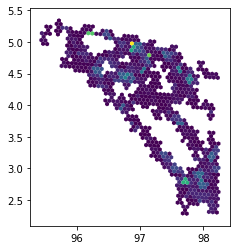

In [6]:
gdf_res6 = convert_raster_h3(
    "../../datasets/processed/Satelligence_data/biodiversity_analysis/biodiversity_loss_ha_upsample.tif",
    "../../datasets/processed/Satelligence_data/test_rasters_2/satelligence_mills_4326_50kmbuffer.shp",
    column="biodiversi",
    resolution=6,
)

gdf_res6.head()

### Resolution 5:


/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,gfw_fid,biodiversi,geometry,estimate
0,706,200.138293908663,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ...",43.937572
1,717,295.5592552826714,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ...",95.903854
2,264,400.8360709155834,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ...",112.520752
3,738,469.4242228971635,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ...",209.463501
4,1516,448.9605690952982,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ...",121.099487


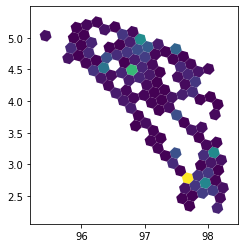

In [7]:
gdf_res5 = convert_raster_h3(
    "../../datasets/processed/Satelligence_data/biodiversity_analysis/biodiversity_loss_ha_upsample.tif",
    "../../datasets/processed/Satelligence_data/test_rasters_2/satelligence_mills_4326_50kmbuffer.shp",
    column="biodiversi",
    resolution=5,
)

gdf_res5.head()

### Ingesting raw data and calculate it on ddbb:

In [9]:
## upsample the high density species as mask for ingesting - max in resampling to get 1 values
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 0.0833333333333286 0.0833333333333286 -r max  -multi -of GTiff '../../datasets/processed/Satelligence_data/biodiversity_analysis/SpeciesRichness_high_density_mask.tif' '../../datasets/processed/Satelligence_data/biodiversity_analysis/SpeciesRichness_high_density_mask_upsample.tif'

Creating output file that is 43P x 46L.
Processing ../../datasets/processed/Satelligence_data/biodiversity_analysis/SpeciesRichness_high_density_mask.tif [1/1] : 0Using internal nodata values (e.g. 0) for image ../../datasets/processed/Satelligence_data/biodiversity_analysis/SpeciesRichness_high_density_mask.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


,h3index,value,geometry
0,0x866553c47ffffff,0.000060,"POLYGON ((95.22458 5.24807, 95.22723 5.28457, ..."
1,0x866553c57ffffff,0.000060,"POLYGON ((95.26041 5.30049, 95.26307 5.33699, ..."
2,0x86650d267ffffff,0.000381,"POLYGON ((97.99217 3.06624, 97.99511 3.10243, ..."
3,0x86650d34fffffff,0.000381,"POLYGON ((98.01934 3.00955, 98.02228 3.04574, ..."
4,0x866572c97ffffff,0.000381,"POLYGON ((97.95618 3.01436, 97.95911 3.05055, ..."


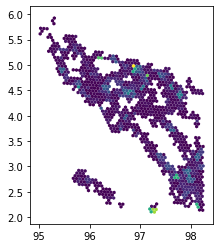

In [10]:
raster_path = (
    "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_Density.tif"
)
with rio.open(raster_path) as src:
    gdf_densres6 = raster.raster_to_geodataframe(
        src.read(1),
        src.transform,
        h3_resolution=6,
        nodata_value=src.profile["nodata"],
        compacted=False,
    )
    gdf_densres6.plot("value")
    gdf_densres6["h3index"] = gdf_densres6["h3index"].apply(hex)
gdf_densres6.head()

,h3index,value,geometry
0,0x866508247ffffff,1.0,"POLYGON ((98.27966 4.24863, 98.28264 4.28497, ..."
1,0x86650824fffffff,1.0,"POLYGON ((98.21628 4.25352, 98.21926 4.28987, ..."
2,0x866508257ffffff,1.0,"POLYGON ((98.31582 4.30070, 98.31881 4.33705, ..."
3,0x86650825fffffff,1.0,"POLYGON ((98.25244 4.30560, 98.25542 4.34196, ..."
4,0x866508267ffffff,1.0,"POLYGON ((98.30687 4.19166, 98.30985 4.22800, ..."


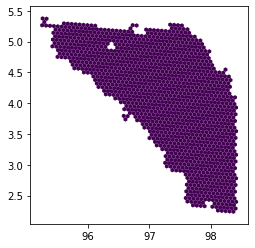

In [11]:
raster_path = "../../datasets/processed/Satelligence_data/biodiversity_analysis/SpeciesRichness_high_density_mask_upsample.tif"
with rio.open(raster_path) as src:
    gdf_speciesres6 = raster.raster_to_geodataframe(
        src.read(1),
        src.transform,
        h3_resolution=6,
        nodata_value=src.profile["nodata"],
        compacted=False,
    )
    gdf_speciesres6.plot("value")
    gdf_speciesres6["h3index"] = gdf_speciesres6["h3index"].apply(hex)
gdf_speciesres6.head()

In [12]:
merge = gdf_densres6.merge(gdf_speciesres6, on="h3index", how="inner")
merge.head()

,h3index,value_x,geometry_x,value_y,geometry_y
0,0x86650d267ffffff,0.000381,"POLYGON ((97.99217 3.06624, 97.99511 3.10243, ...",1.0,"POLYGON ((97.99217 3.06624, 97.99511 3.10243, ..."
1,0x86650d34fffffff,0.000381,"POLYGON ((98.01934 3.00955, 98.02228 3.04574, ...",1.0,"POLYGON ((98.01934 3.00955, 98.02228 3.04574, ..."
2,0x866572c97ffffff,0.000381,"POLYGON ((97.95618 3.01436, 97.95911 3.05055, ...",1.0,"POLYGON ((97.95618 3.01436, 97.95911 3.05055, ..."
3,0x866572197ffffff,0.002318,"POLYGON ((97.63157 2.92980, 97.63447 2.96598, ...",1.0,"POLYGON ((97.63157 2.92980, 97.63447 2.96598, ..."
4,0x866572567ffffff,0.002318,"POLYGON ((97.66751 2.98168, 97.67041 3.01786, ...",1.0,"POLYGON ((97.66751 2.98168, 97.67041 3.01786, ..."


In [13]:
h3index_array = []
value_array = []
for i, row in merge.iterrows():
    density = row["value_x"]
    h3index = row["h3index"]
    value = density * 3612.9
    value_array.append(value)
    h3index_array.append(h3index)

gdf_estimate = gpd.GeoDataFrame()
gdf_estimate["h3index"] = h3index_array
gdf_estimate["value"] = value_array
gdf_estimate.head()

,h3index,value
0,0x86650d267ffffff,1.378058
1,0x86650d34fffffff,1.378058
2,0x866572c97ffffff,1.378058
3,0x866572197ffffff,8.375731
4,0x866572567ffffff,8.375731


In [14]:
clean_sat_mills.head()

,gfw_fid,deforestat,biodiversi,carbon,geometry
0,706,349.5068535490499,200.138293908663,57812.37323319753,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ..."
1,717,444.9278149230584,295.5592552826714,74432.2796810086,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ..."
2,264,552.3038111406324,400.8360709155834,95543.40760696075,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ..."
3,738,621.1470874150178,469.4242228971635,109557.3760590317,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ..."
4,1516,600.0120538952435,448.9605690952982,104970.0756673934,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ..."


In [15]:
bio_sum_calculated = []
for i, row in clean_sat_mills.iterrows():
    filtered_gdf = clean_sat_mills[i : i + 1]
    # convert to h3
    h3_gdf = filtered_gdf.h3.polyfill_resample(6)
    h3index_list = [f"0x{h3index}" for h3index in h3_gdf.index]
    # filter gdf by list and get value
    # 3617 is the area of the hexagon for res6 in
    bio_sum = gdf_estimate[gdf_estimate["h3index"].isin(h3index_list)]["value"].sum()
    bio_sum_calculated.append(bio_sum)

In [16]:
clean_sat_mills["ddbb_calc_res6"] = bio_sum_calculated
clean_sat_mills["res6_precalc"] = list(gdf_res6["estimate"])
clean_sat_mills["res5_precalc"] = list(gdf_res5["estimate"])
clean_sat_mills.head()

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,gfw_fid,deforestat,biodiversi,carbon,geometry,ddbb_calc_res6,res6_precalc,res5_precalc
0,706,349.5068535490499,200.138293908663,57812.37323319753,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ...",237.234755,379.696045,43.937572
1,717,444.9278149230584,295.5592552826714,74432.2796810086,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ...",317.167758,569.285217,95.903854
2,264,552.3038111406324,400.8360709155834,95543.40760696075,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ...",426.967292,828.127014,112.520752
3,738,621.1470874150178,469.4242228971635,109557.3760590317,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ...",545.373341,1120.113037,209.463501
4,1516,600.0120538952435,448.9605690952982,104970.0756673934,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ...",419.375901,814.255249,121.099487


In [17]:
clean_sat_mills.to_csv(
    "../../datasets/processed/Satelligence_data/biodiversity_analysis/biodiversity_stats_h3.csv"
)

## Check satelligence deforestation using distinct:

1. Translate raster to h3 using density and res 6
2. Use distinct query to compute deforestation




In [ ]:
def convert_raster_h3(raster_path, vector_path, column="deforestat", resolution=6):
    with rio.open(raster_path) as src:
        gdf = raster.raster_to_geodataframe(
            src.read(1),
            src.transform,
            h3_resolution=resolution,
            nodata_value=src.profile["nodata"],
            compacted=False,
        )

        gdf.plot("value")
        gdf["h3index"] = gdf["h3index"].apply(hex)

    gdf_vector = gpd.read_file(vector_path)
    clean_gdf = gdf_vector[["gfw_fid", column, "geometry"]]

    _sum_calculated = []
    for i, row in clean_gdf.iterrows():
        filtered_gdf = clean_gdf[i : i + 1]
        # convert to h3
        h3_gdf = filtered_gdf.h3.polyfill_resample(resolution)
        # h3_gdf = h3_gdf.reset_index().rename(columns={'h3_polyfill':'h3index'})
        h3index_list = [f"0x{h3index}" for h3index in h3_gdf.index]
        # filter gdf by list and get value
        _sum = gdf[gdf["h3index"].isin(h3index_list)]["value"].sum()
        _sum_calculated.append(_sum)

    clean_gdf["estimate"] = _sum_calculated
    return clean_gdf

In [ ]:
gdf = convert_raster_h3(
    "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_Density.tif",
    "../../datasets/processed/Satelligence_data/test_rasters_2/satelligence_mills_4326_50kmbuffer.shp",
    column="deforestat",
    resolution=6,
)
_estimated = [el * 3612.9 for el in gdf["estimate"]]
gdf["estimate"] = _estimated
gdf.head()

In [26]:
# raster to translate
# sat_def_raster = "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_Density.tif"
sat_def_raster = "../../datasets/processed/Satelligence_data/Deforestation_IDN_2021-01-01-2022-01-01_areaSum_ha.tif"

mills_locations = "../../datasets/processed/Satelligence_data/test_rasters_2/satelligence_mills_4326_50kmbuffer.shp"
resolution = 6

,h3index,value,geometry
0,0x86657374fffffff,11.959510,"POLYGON ((95.99883 2.77929, 96.00155 2.81546, ..."
1,0x866550417ffffff,5.858907,"POLYGON ((96.06363 4.91120, 96.06637 4.94766, ..."
2,0x866550437ffffff,5.858907,"POLYGON ((96.09131 4.85415, 96.09406 4.89060, ..."
3,0x866550407ffffff,0.026855,"POLYGON ((96.02770 4.85888, 96.03045 4.89533, ..."
4,0x86655040fffffff,0.026855,"POLYGON ((95.96409 4.86360, 95.96683 4.90006, ..."


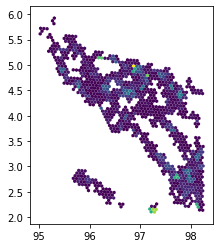

In [27]:
# translate raster to h3
with rio.open(sat_def_raster) as src:
    gdf = raster.raster_to_geodataframe(
        src.read(1),
        src.transform,
        h3_resolution=resolution,
        nodata_value=src.profile["nodata"],
        compacted=False,
    )

    gdf.plot("value")
    gdf["h3index"] = gdf["h3index"].apply(hex)
gdf.head()

In [28]:
gdf_vector = gpd.read_file(mills_locations)
# gdf_vector
clean_gdf = gdf_vector[["gfw_fid", "deforestat", "geometry"]]
clean_gdf.head()

,gfw_fid,deforestat,geometry
0,706,349.5068535490499,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ..."
1,717,444.9278149230584,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ..."
2,264,552.3038111406324,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ..."
3,738,621.1470874150178,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ..."
4,1516,600.0120538952435,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ..."


In [31]:
_sum_calculated = []
for i, row in clean_gdf.iterrows():
    filtered_gdf = clean_gdf[i : i + 1]
    # convert to h3
    h3_gdf = filtered_gdf.h3.polyfill_resample(resolution)
    # h3_gdf = h3_gdf.reset_index().rename(columns={'h3_polyfill':'h3index'})
    h3index_list = [f"0x{h3index}" for h3index in h3_gdf.index]
    # filter gdf by list and get value
    _sum = sum((gdf[gdf["h3index"].isin(h3index_list)]["value"]).unique())
    _sum_calculated.append(_sum)

clean_gdf["estimate"] = _sum_calculated
_estimated = [el for el in clean_gdf["estimate"]]
clean_gdf["estimate"] = _estimated
clean_gdf.head()

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,gfw_fid,deforestat,geometry,estimate
0,706,349.5068535490499,"POLYGON ((98.47767 2.24508, 98.47705 2.22159, ...",365.641333
1,717,444.9278149230584,"POLYGON ((98.44488 2.31416, 98.44426 2.29068, ...",449.477260
2,264,552.3038111406324,"POLYGON ((98.40582 2.39111, 98.40521 2.36762, ...",641.739516
3,738,621.1470874150178,"POLYGON ((98.36445 2.43594, 98.36383 2.41245, ...",737.965135
4,1516,600.0120538952435,"POLYGON ((98.51418 2.45678, 98.51356 2.43329, ...",609.284527


In [32]:
clean_gdf.to_csv(
    "../../datasets/processed/Satelligence_data/deforestation_stats_areasum_unique_h3.csv"
)